# Analysing data

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')

# Rolling Averages

Creating new data array at one single point to save memory and decrease computation time, this can be changed later on.

In [8]:
longitude = -4.5
latitude = 54.25


power_ds = ds.sel(latitude=[latitude], longitude=[longitude])['power']

#creating rolling averages
power_ds['4hr_avg'] = power_ds.rolling(time=4).mean()
power_ds['8hr_avg'] = power_ds.rolling(time=8).mean()
power_ds['12hr_avg'] = power_ds.rolling(time=12).mean()
power_ds['24hr_avg'] = power_ds.rolling(time=24).mean()
power_ds['48hr_avg'] = power_ds.rolling(time=48).mean()
power_ds['36hr_avg'] = power_ds.rolling(time=36).mean()
power_ds['1w_avg'] = power_ds.rolling(time=168).mean()
power_ds['2w_avg'] = power_ds.rolling(time=336).mean()

## 12 hour rolling average

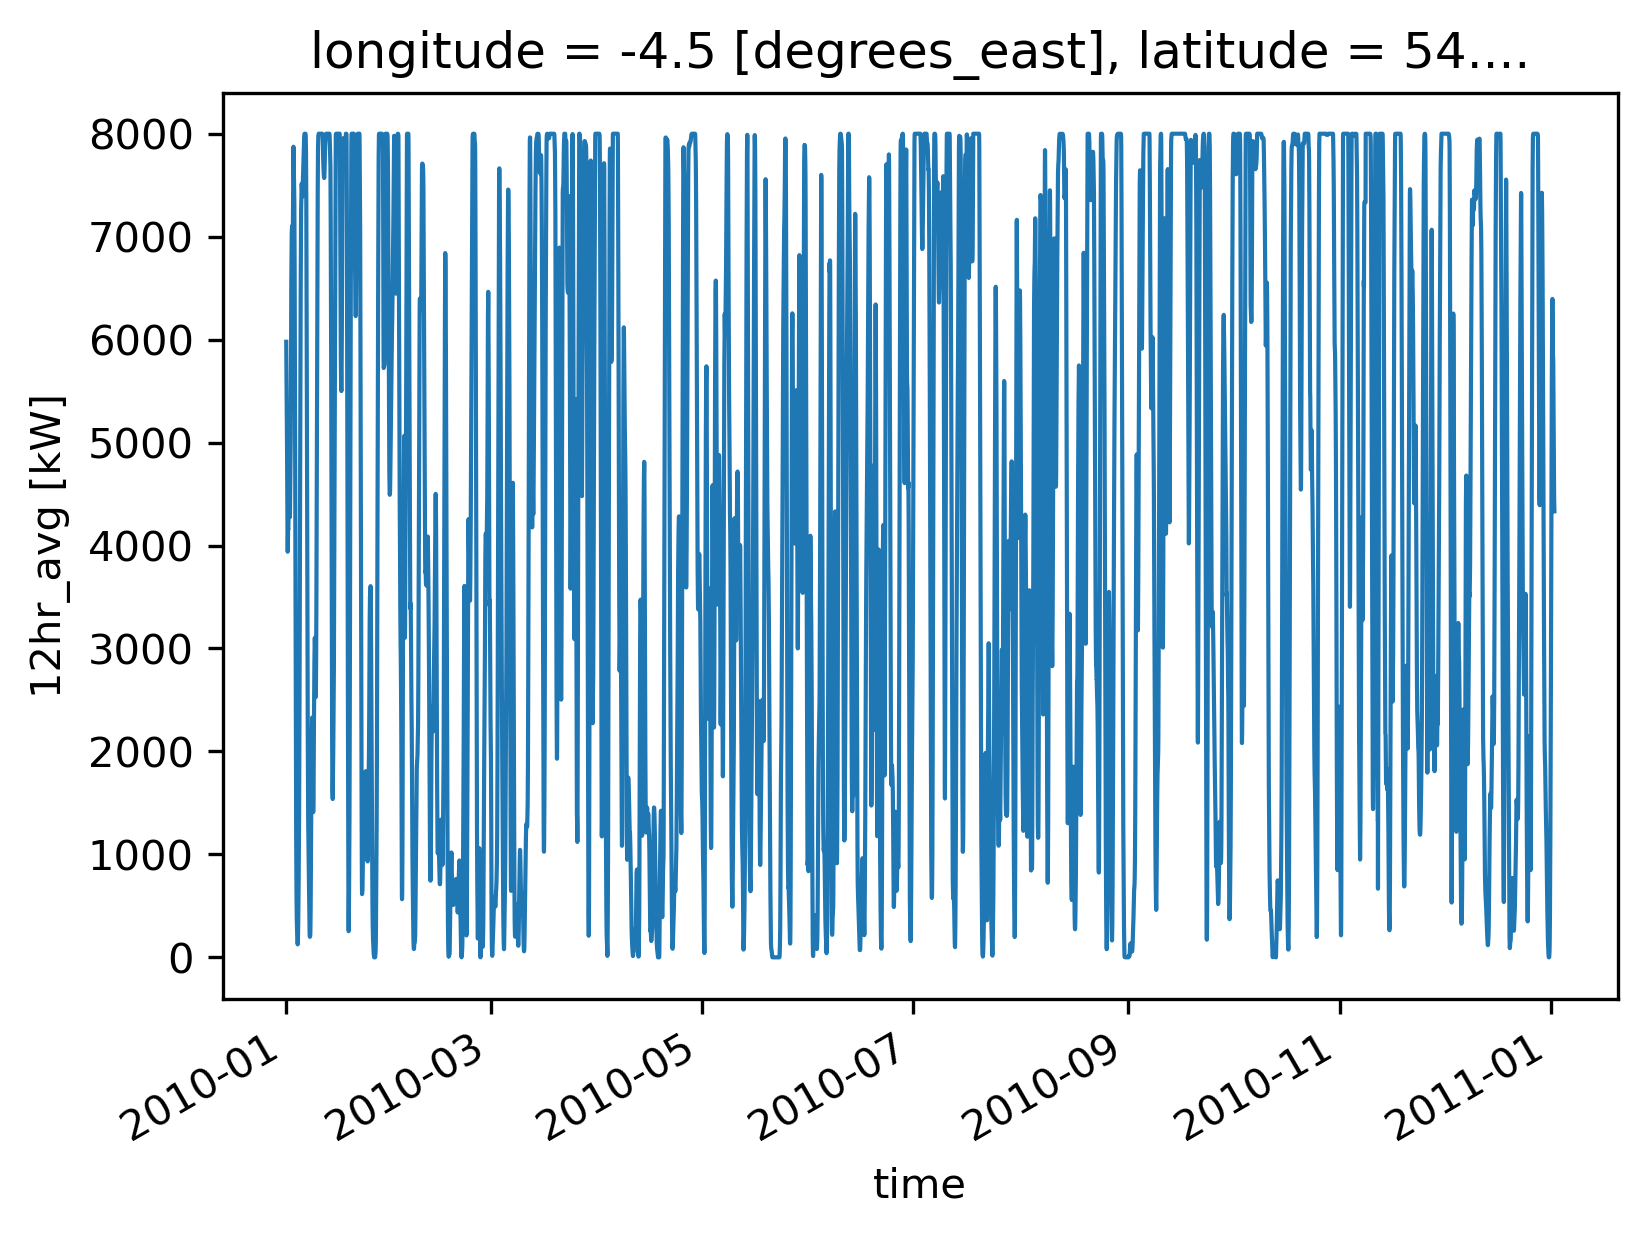

In [9]:
plt.figure(dpi=300)
power_ds['12hr_avg'].sel(time=slice('2010-01-01', '2011-01-01')).plot(linewidth=1)

## 36 hour rolling average

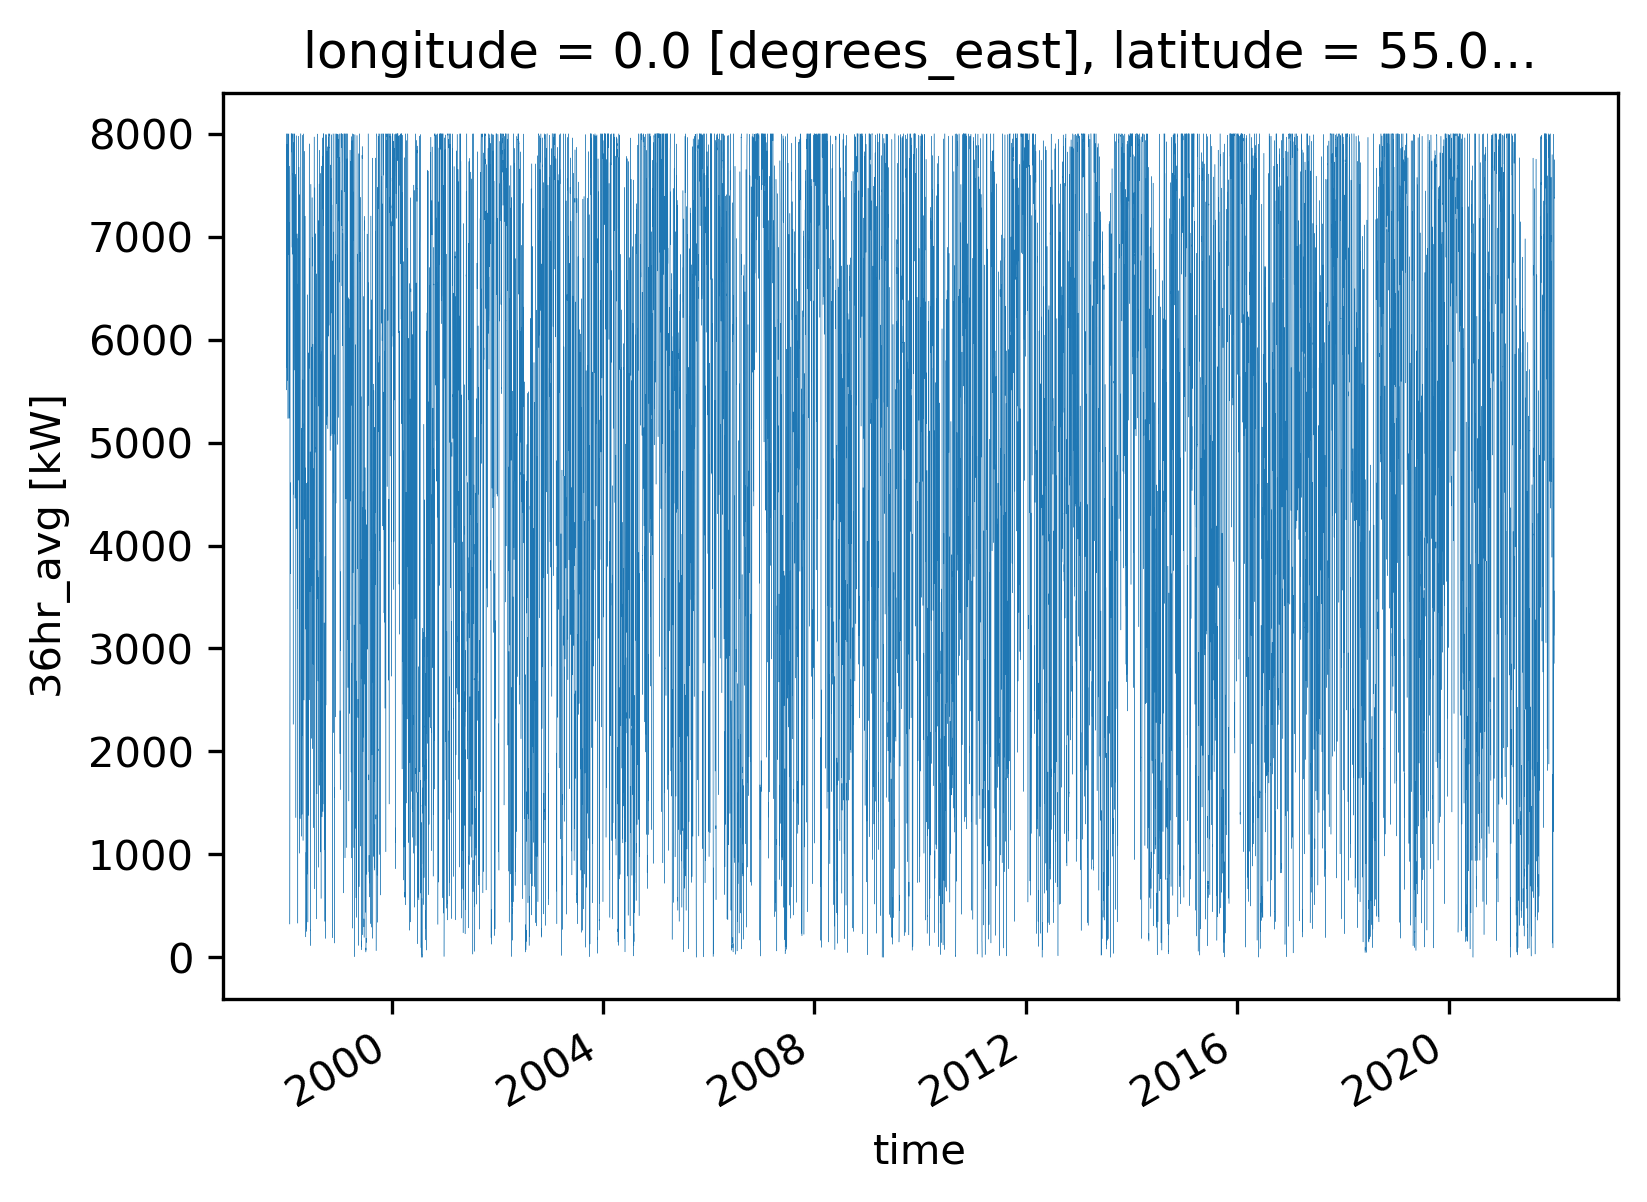

In [15]:
plt.figure(dpi=300)
power_ds['36hr_avg'].plot(linewidth=0.1)

## 36 hour rolling average with a slice of time

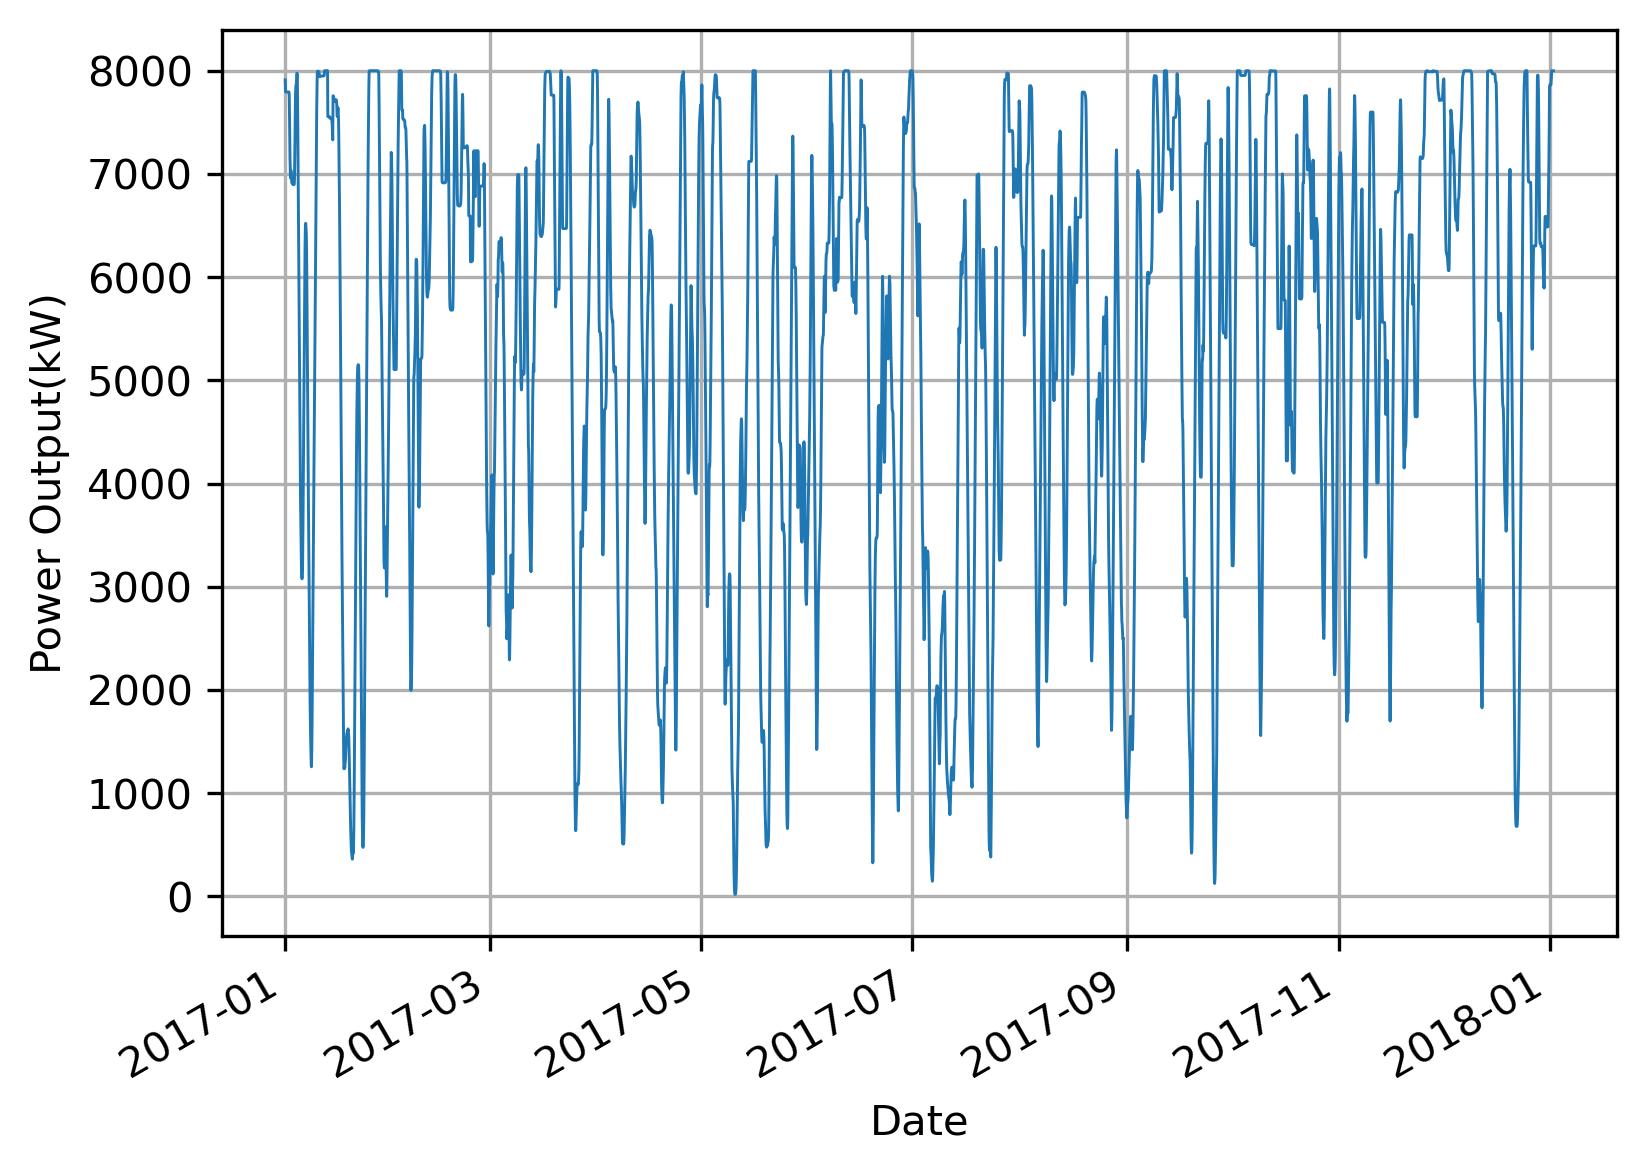

In [5]:
plt.figure(dpi=300)
power_ds['36hr_avg'].sel(
    time=slice('2017-01-01', '2018-01-01')).plot(linewidth=0.7)
plt.title(f'36hr Rolling Average at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.title(f'')
plt.xlabel('Date')
plt.ylabel('Power Output(kW)')
plt.grid()

plt.savefig(f'./figures/36hr_rolling_avg{latitude}N_{longitude}E.pdf',bbox_inches='tight')

# Graphing the number of Lulls and their length

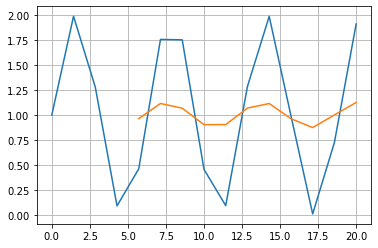

In [136]:
N = 15
length = 20
windowsize=5
x = np.linspace(0,length,N)
sin = np.sin(x) + 1
time = np.arange(N)
sin_ds = xr.DataArray(data=sin,dims=['time'],coords=dict(time=time))
sin_avg = sin_ds.rolling(time=windowsize).mean()
plt.plot(x,sin)
plt.plot(x,sin_avg)
plt.grid()

In [137]:
num = sin_avg.where(sin_avg < 1)
num_next = num.where((num.shift(time=+1).isnull() != False) & (num.shift(time=-1).isnull() != False))
count = num_next.count(dim='time').values
print(num)  
print(num_next)
print(count)

<xarray.DataArray (time: 15)>
array([       nan,        nan,        nan,        nan, 0.96429605,
              nan,        nan, 0.90360836, 0.9041353 ,        nan,
              nan, 0.9635247 , 0.87417303,        nan,        nan])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
<xarray.DataArray (time: 15)>
array([       nan,        nan,        nan,        nan, 0.96429605,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
1


In [155]:
avg_nums = np.logspace(0,2.5265,40, dtype='int')
avg_nums = np.arange(1,337) #1hr to 2 weeks
num_lulls = np.empty(avg_nums.shape[0],dtype='float64')
start_date = '1998-01-01' #1998-01-01
end_date = '2021-12-31' #2021-12-31
cut_off = 0.01
max_power = 8000*cut_off
num_yrs = 24


for i in range(avg_nums.shape[0]):
    #start = time.time()
    working_ds = (ds.sel(time=slice(start_date, end_date), latitude=[latitude], longitude=[longitude])['power']
                  .rolling(time=avg_nums[i])
                  .mean())
    
    num = (working_ds.where(working_ds < max_power))
    num_next = num.where((num.shift(time=+1).isnull() != False) & (num.shift(time=-1).isnull() != False))
    num_lulls[i] = num_next.count(dim='time').values 
    
    #end = time.time()
    #print('Time taken for',avg_nums[i],':',np.round((end-start),decimals=2),'secs')

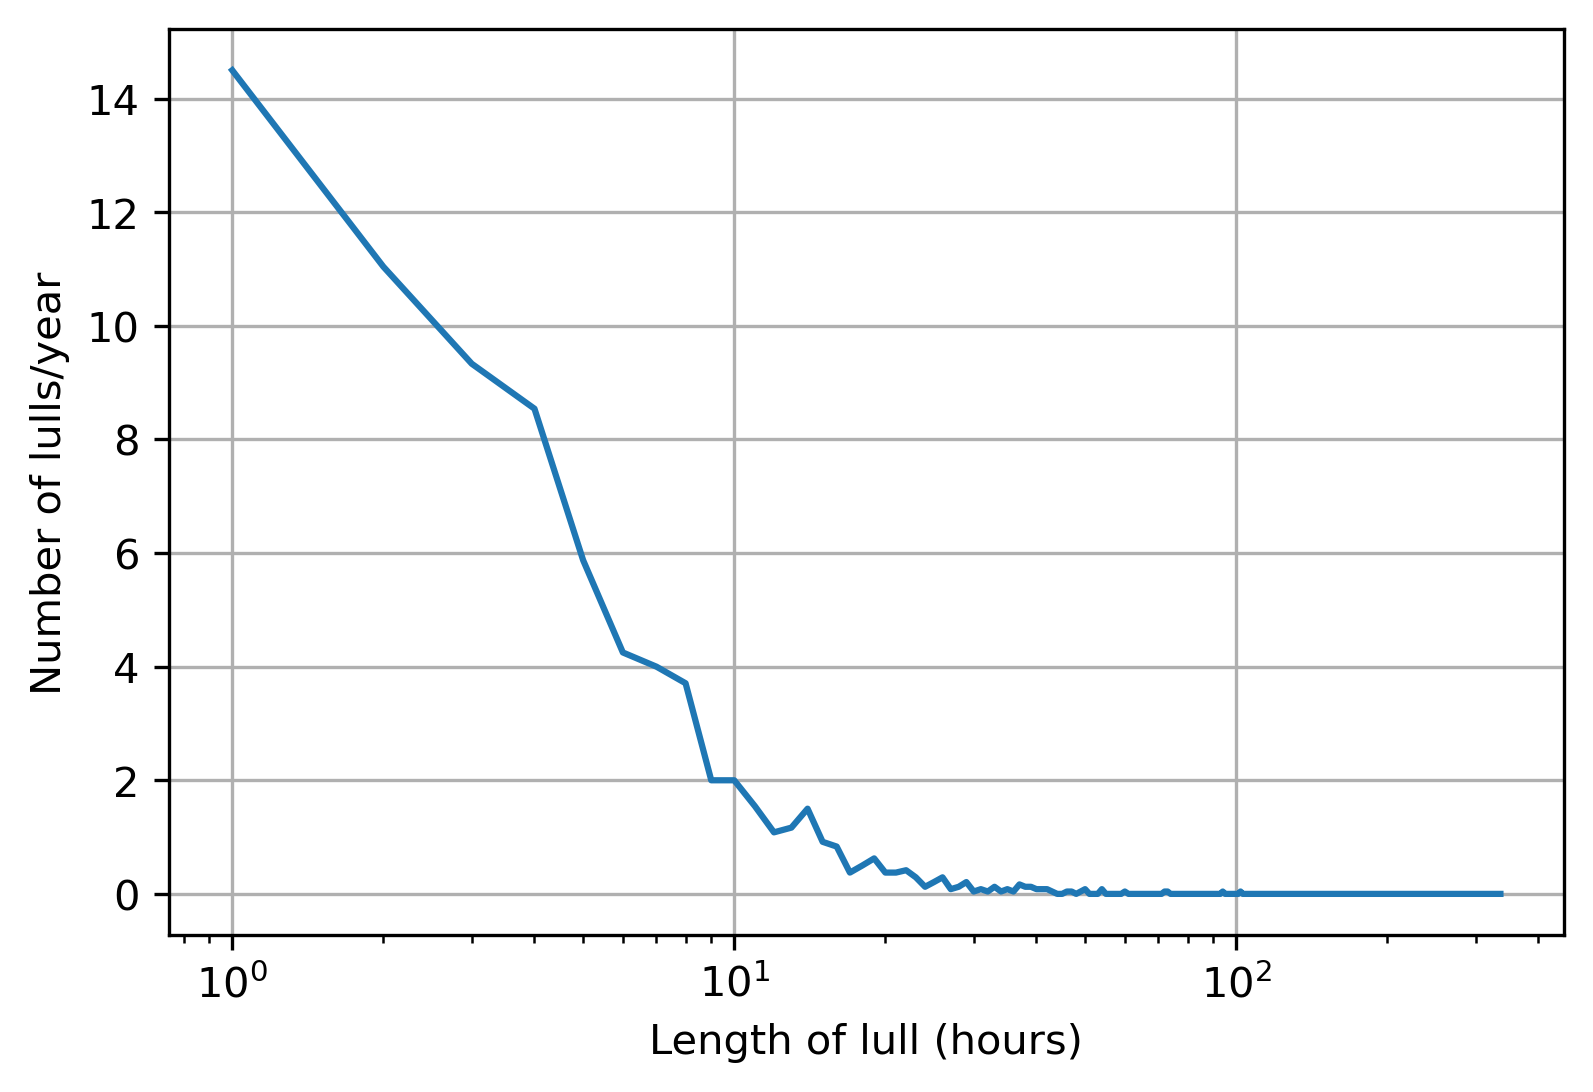

In [156]:
plt.figure(dpi=300)
plt.semilogx(avg_nums,num_lulls/num_yrs)
plt.xlabel('Length of lull (hours)')
plt.ylabel('Number of lulls/year')
plt.title(f'Number of lulls over lull length at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.title('')
plt.grid()
plt.savefig('./figures/single_lull.pdf',bbox_inches='tight')

In [118]:
#OLD ONE

avg_names = ['4hr_avg','8hr_avg','12hr_avg','24hr_avg','36hr_avg','48hr_avg','1w_avg', '2w_avg']
avg_nums = np.array([4,8,12,24,36,48,168,336])
avg_nums = np.logspace(0,2.5265,8, dtype='int')
num_lulls = np.empty(avg_nums.shape[0],dtype='float64')
start_date = '1998-01-01' #1998-01-01
end_date = '2021-12-31' #2021-12-31
cut_off = 0.01
max_power = 8000*cut_off
num_yrs = 24


for i, name in enumerate(avg_names):
    start = time.time()
    working_ds = (ds.sel(time=slice(start_date, end_date), latitude=[latitude], longitude=[longitude])['power']
                  .rolling(time=avg_nums[i])
                  .mean())
    
    num_lulls[i] = (working_ds.where(working_ds < max_power)
                    .count(dim='time')
                    .values)
    end = time.time()
    print('Time taken for',len(avg_names),'calculations:',np.round((end-start),decimals=2),'secs')

Time taken for 8 calculations: 2.52 secs
Time taken for 8 calculations: 2.65 secs
Time taken for 8 calculations: 2.64 secs
Time taken for 8 calculations: 2.49 secs
Time taken for 8 calculations: 2.43 secs
Time taken for 8 calculations: 2.45 secs
Time taken for 8 calculations: 2.48 secs
Time taken for 8 calculations: 2.5 secs


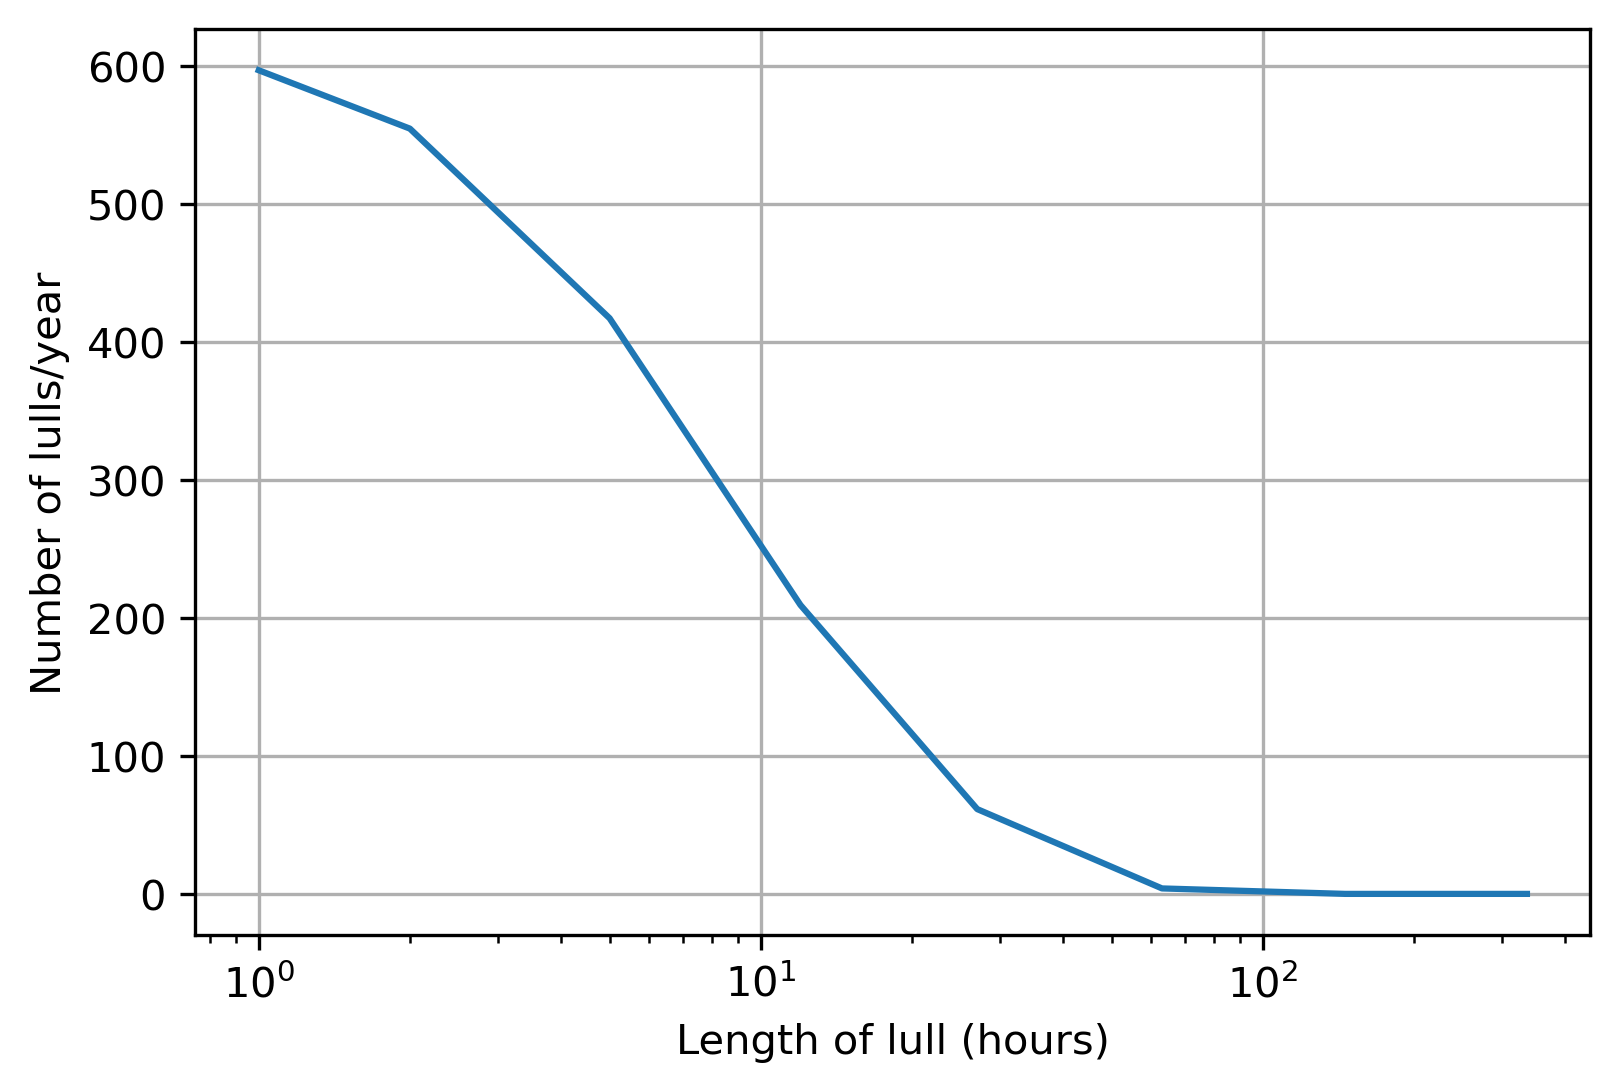

In [119]:
plt.figure(dpi=300)
plt.semilogx(avg_nums,num_lulls/num_yrs)
plt.xlabel('Length of lull (hours)')
plt.ylabel('Number of lulls/year')
plt.title(f'Number of lulls over lull length at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.title('')
plt.grid()
plt.savefig('./figures/single_lull.pdf',bbox_inches='tight')

# Looking at Firm Capacity

Firm capacity is the proportion of the time that wind turbine provides a certain percentage (x%) of its installed capacity. Below I am going to plot this information for a range of firm capacities.

In [12]:
loss_factor = 1
agg_power = ds.sel(latitude=[latitude], longitude=[longitude])['power'].sum(dim='latitude').sum(dim='longitude')*loss_factor
agg_power.head().compute()

<xarray.DataArray 'power' (time: 5)>
array([7138.1406, 7844.75  , 7992.8438, 8000.    , 8000.    ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 ... 1998-01-01T04:00:00

In [13]:
#calculating firm capacity
ratios = np.linspace(0,1,22)
power_limit = ratios * 8000
firm_capacity = np.empty(ratios.shape)
arr_length = agg_power.shape[0]
#arr_length = ds.sel(latitude=[latitude], longitude=[longitude])['power'].shape[0]

start= time.time()
for i, ratio in enumerate(ratios):
    #working_ds = ds.sel(latitude=[latitude], longitude=[longitude])['power']
    working_ds = agg_power
    val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
    firm_capacity[i] = val/arr_length
end = time.time()
print('Time taken for',ratios.shape[0],'calculations:',np.round((end-start),decimals=2))

Time taken for 22 calculations: 52.85


Firm Capacities: [1.         0.89201175 0.84919481 0.81208647 0.77937961 0.74907788
 0.72033044 0.69418777 0.66944254 0.64698361 0.62542304 0.60528842
 0.58689349 0.5691545  0.55185756 0.53522606 0.51813826 0.50382634
 0.48685261 0.46465511 0.43140163 0.3277388 ] at ( 54.25 , -4.5 )


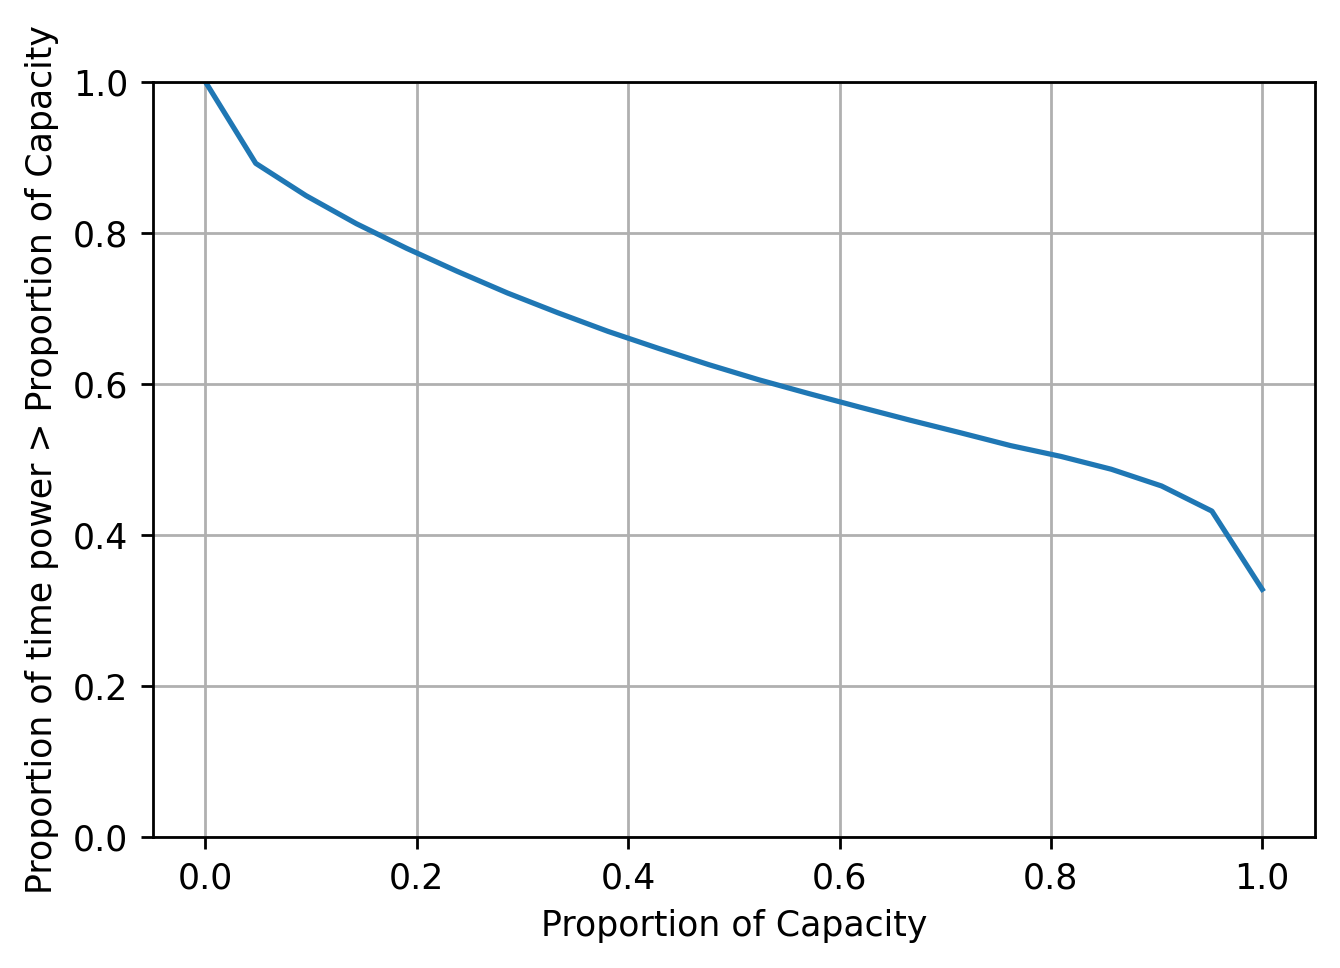

In [14]:
print('Firm Capacities:',firm_capacity,'at (',latitude,',',longitude,')')
plt.figure(dpi=250)
plt.plot(ratios, firm_capacity)
plt.ylim(0,1)
plt.title(f'Firm Capacity over a range at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.title(f'')
plt.xlabel('Proportion of Capacity')
plt.ylabel('Proportion of time power > Proportion of Capacity')
plt.grid()
plt.savefig('./figures/firm_capacity_single.pdf',bbox_inches='tight')

# Capacity Factor

In [12]:
longitude = 0
latitude = 55

ds_cpf = ds['power'].sel(latitude=[latitude], longitude=[longitude]).mean(dim='time').to_numpy()[0][0]
print('Capacity factor:',np.round(ds_cpf/80, decimals=2))

Capacity factor: 61.5


# Average Wind Speed

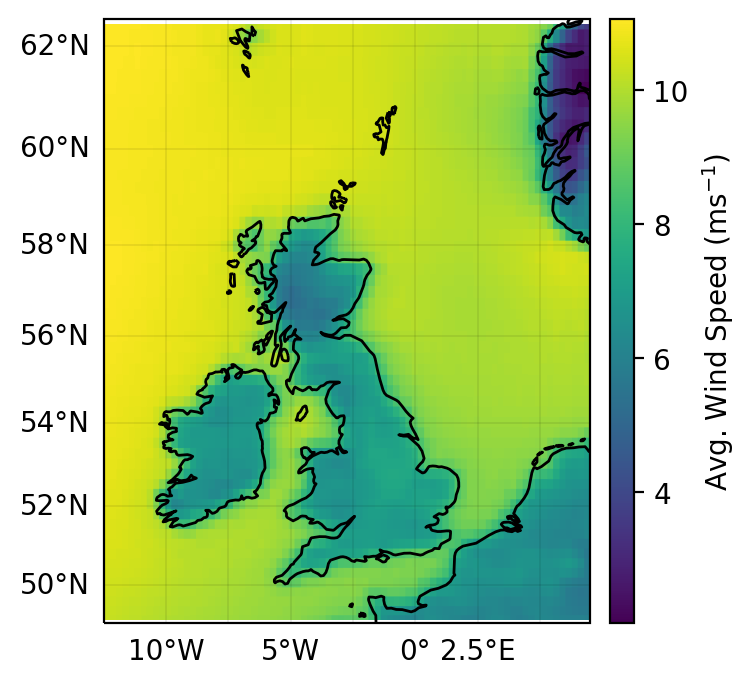

In [16]:
ds_mean = ds.mean(dim='time')['wind_mag'].transpose()

edge =-0.05
#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Average Wind Speed')
plt.title('')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')
img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])
z = ax.imshow(ds_mean, origin='lower', extent=img_extent, transform = ccrs.PlateCarree())

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

fig.add_axes(ax_cb)
plt.colorbar(z, cax=ax_cb, label=r'Avg. Wind Speed (ms$^{-1}$)')
plt.savefig('./figures/avg_wind_speed_map.pdf',bbox_inches='tight')